In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import os.path
from os import path
import seaborn as sns
from scipy import signal

In [6]:
## 1, -- KDP_nu
KDP_nu_name=["CIR40" ,"CIR50"]
KDP_nu=[1,1.25]

## 2,  --  KDP_w_sat_1  -- -
KDP_w_sat_1_name=["0_33" ,"0_66" ,"1_00"]
KDP_w_sat_1=[0.33, 0.66 ,1.00]

## 3,  --  KDP_w_sat_2  -- -
KDP_w_sat_2_name=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
KDP_w_sat_2=[380, 442 ,503]

## 4,  --  KDP_g_1  -- -
KDP_g_1_name=["0_33", "0_66" ,"1_00"]
KDP_g_1=[0.33, 0.66, 1.00]

## 5,  --  KDP_g_2  -- -
KDP_g_2_name=["ABW150Days" ,"ABW180Days"]
KDP_g_2=[150 ,180]

## 6,  --  KDP_c_p  -- -
KDP_c_p_name=["Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent"]
KDP_c_p=[1 ,1.5, 2]

KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
KDP_lambda=[0,0.1,0.2]


In [43]:
def ReadDF(fname):
    df_master = pd.DataFrame()
    dateOfPeak = []
    dayOfPeak = []
    numAtPeak = []
    vaccRate = []
    numRead = 0
    for i in range(len(KDP_nu)):
            for j in range(len(KDP_w_sat_1)):
                for k in range(len(KDP_w_sat_2)):
                    for l in range(len(KDP_g_1_name)):
                        for m in range(len(KDP_g_2)):
                            for n in range(len(KDP_c_p)):
                                for o in range(len(KDP_lambda)):
                                    if(path.exists(KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]+"/PopulationData/"+ fname)):
                                        df_temp = pd.read_csv(KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]+"/PopulationData/"+fname, delim_whitespace=True, header=1).transpose().loc['Total':]



                                        ExptId = KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]
                                        VaccineRt = str(KDP_c_p_name[n])
                                        CIR = str(KDP_nu_name[i]) 
                                        SD = str(KDP_lambda_name[o])
                                        KDPwsat = str(KDP_w_sat_2_name[k])

                                        numRead+=1


                                        df_temp['ID'] = ExptId
                                        df_temp['Vaccine Rate'] = VaccineRt
                                        df_temp['CIR'] = CIR
                                        df_temp['SD'] = SD
                                        df_temp['KDPwsat2']=KDPwsat
                                        df_temp['Scenario'] = numRead
                                                                
                                        df_master = pd.concat([df_master,df_temp])


    print(str(numRead) + " samples have been read ")
    return df_master
                                    

In [44]:
df_active= ReadDF("CovidPopulation.data")


972 samples have been read 


In [45]:
import scipy
def AddPeakInfo(df_master):
    dateOfPeak = []
    numAtPeak = []
    for ia in range(len(df_master)):
        dop = scipy.signal.find_peaks(df_master.iloc[[ia]].transpose().loc[0:730,'Total'],distance = 20)
        for ib in range(len(dop[0])):
            if (dop[0][ib]>365):
                dateOfPeak.append(dop[0][ib])
                numAtPeak.append(df_master.iloc[ia,dop[0][ib]])
                break
            if(ib)==len(dop[0])-1:
                #print("Scenario " + str(ia) + " Does Not Have a Peak ")
                dateOfPeak.append(float('nan'))
                numAtPeak.append(float('nan'))
    df_master['Date Of Peak'] = dateOfPeak
    df_master['Number At Peak'] = numAtPeak
    return df_master

In [46]:
df_active = AddPeakInfo(df_active)




In [50]:

def plot_histo(df,X,hue,bw):
    df_plot=df
    df_plot.dropna(subset=['Date Of Peak'],inplace=True)
    sns.set(rc={'figure.figsize':(20,15)})
    
    sns.histplot(data=df_plot,x=X, hue=hue, binwidth=bw,multiple='dodge',fill=True)
    
    
def plot_violin(X,Y,df,hue,scale):
    df_plot = df
    df_plot.dropna(subset=['Date Of Peak'],inplace=True)
    sns.set(rc={'figure.figsize':(15,10)})
    sns.violinplot(x=X,y=Y,data=df_plot,hue=hue,split=True,scale=scale)



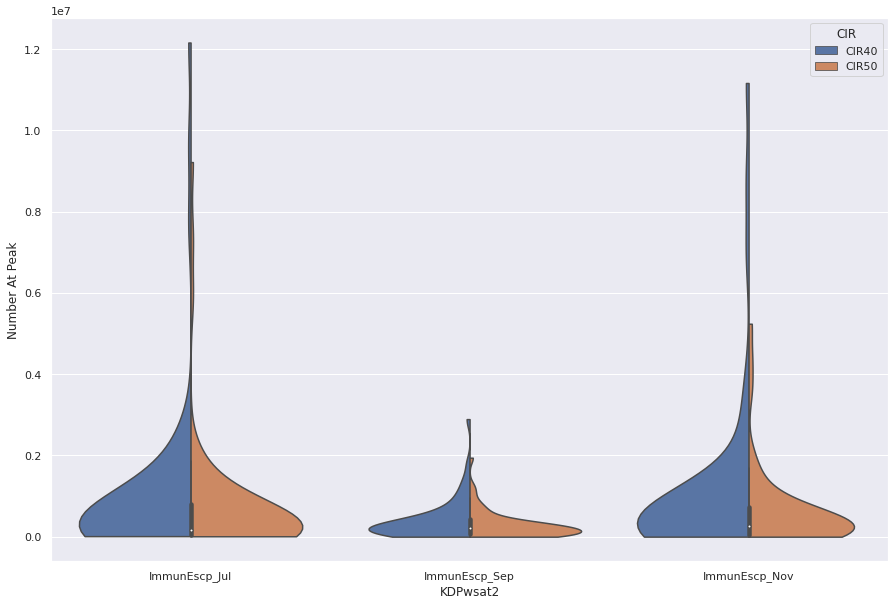

In [48]:
plot_violin('KDPwsat2','Number At Peak',df_active, 'CIR','count')


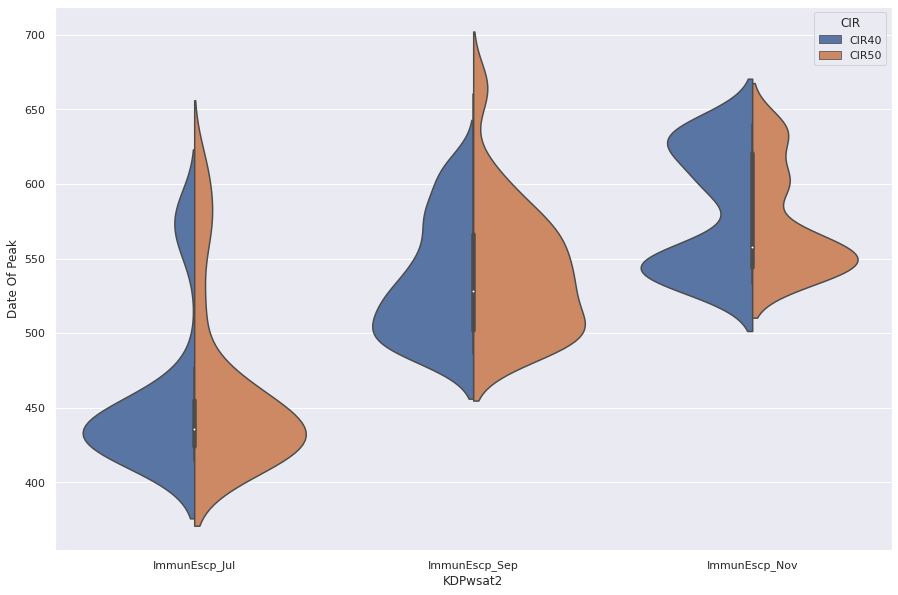

In [51]:
plot_violin('KDPwsat2','Date Of Peak',df_active, 'CIR','count')

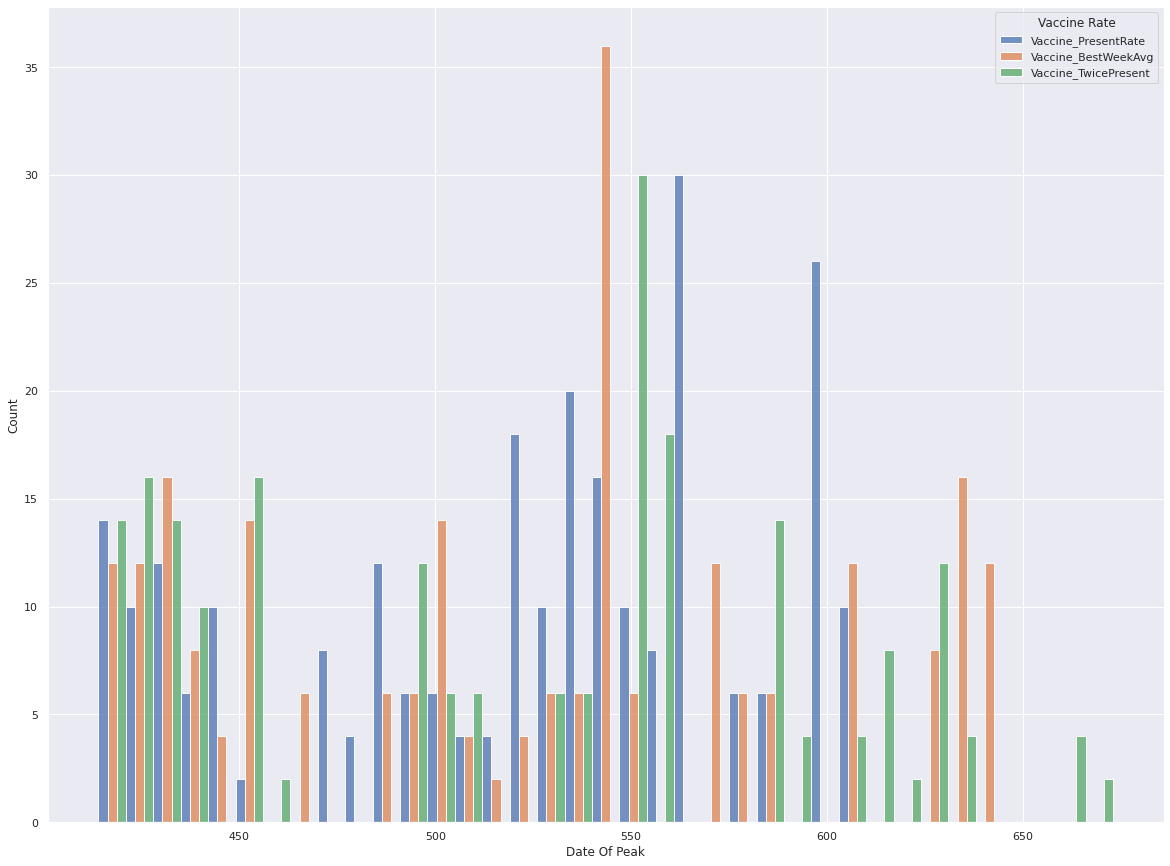

In [23]:
plot_histo(df_active,'Date Of Peak', 'Vaccine Rate', 7)

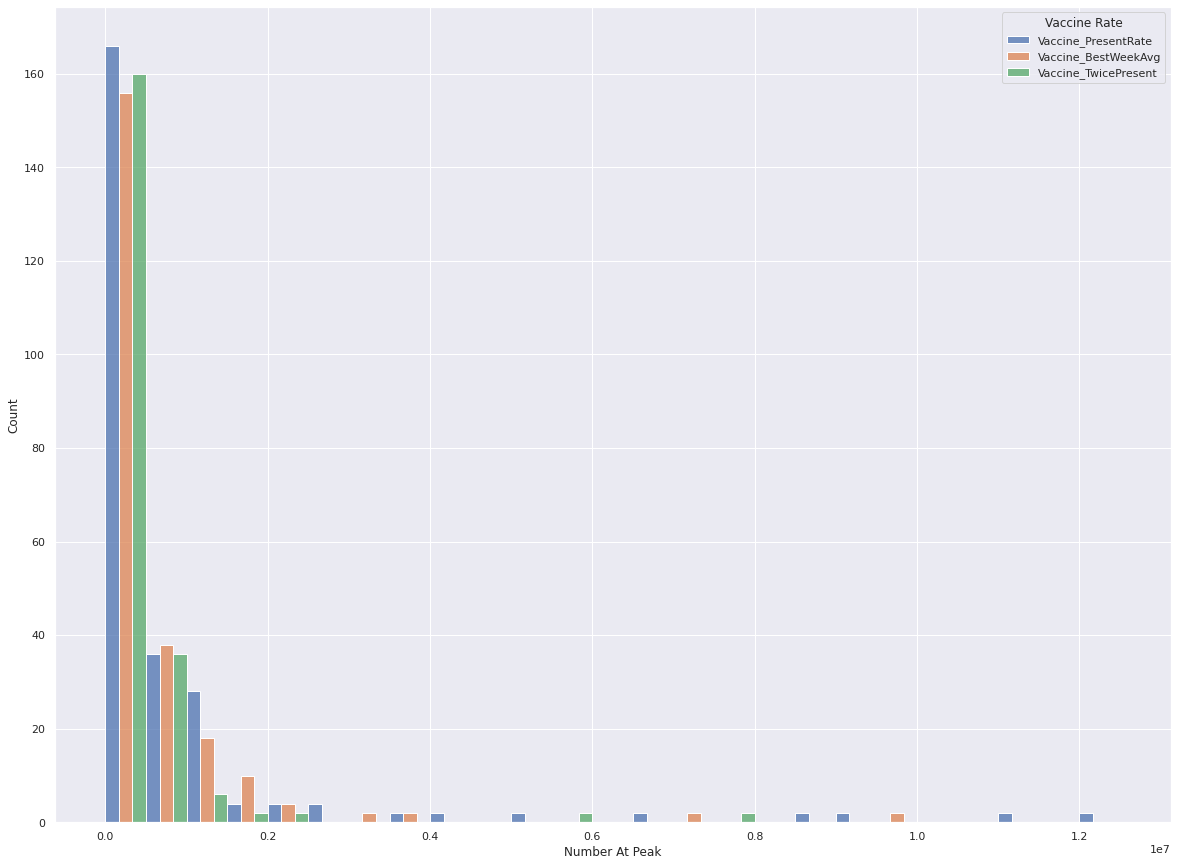

In [24]:
plot_histo(df_active,'Number At Peak','Vaccine Rate',5e5)

In [32]:
def AddMeanInfo(df):
    meanval = []
    minval = []
    maxval = []
    for i in range(731):
        meanval.append(np.mean(df[i]))
        minval.append(np.min(df[i]))
        maxval.append(np.max(df[i]))
    df.append(minval)
    df.append(maxval)
    df.append(meanval)
    
        
        
    

In [33]:
df_active = AddMeanInfo(df_active)

None
